# Download & Process an open fNIRS dataset

Author  : Guillaume Dumas

Date    : 2022-11-16

Note    : This notebook will download ~500MB of data.

## Import library

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


In [2]:
import pooch
from zipfile import ZipFile
import os
import mne
import matplotlib.pyplot as plt
from itertools import compress
import numpy as np
import hypyp

## Download the whole dataset

You can read the [Paper](https://doi.org/10.1038/s41597-022-01751-2) and check the [Data](https://doi.org/10.21979/N9/35DNCW) online.

Pooch doc: https://www.fatiando.org/pooch/latest/

In [3]:
file_path = pooch.retrieve(
    fname="fathers.zip",
    url="https://researchdata.ntu.edu.sg/api/access/datafile/91950?gbrecs=true",
    known_hash="md5:786e0c13caab4fc744b93070999dff63",
    progressbar=True
)

## Uncompress the archive

Note: data is stored in the Pooch's cache folder

ZipFile doc: https://docs.python.org/3/library/zipfile.html


In [4]:
pooch_path = os.path.dirname(file_path)
with ZipFile(file_path, 'r') as zip:
    zip.extractall(path=pooch_path)
data_path = os.path.join(pooch_path, zip.filelist[0].filename)
print(data_path)


/home/patrice/.cache/pooch/fathers/


## Loop through all the dyads and check durations

See data structure here: https://doi.org/10.21979/N9/35DNCW


In [5]:
for dyad in os.listdir(data_path):

    # Load the NIRx data for children and their fathers
    # https://mne.tools/stable/auto_tutorials/io/30_reading_fnirs_data.html

    child_path = os.path.join(data_path, dyad, 'child')
    hdr_child = [f for f in os.listdir(child_path) if f[-3:] == 'hdr'][0]
    raw_child = mne.io.read_raw_nirx(fname=os.path.join(child_path, hdr_child))

    parent_path = os.path.join(data_path, dyad, 'parent')
    hdr_parent = [f for f in os.listdir(parent_path) if f[-3:] == 'hdr'][0]
    raw_parent = mne.io.read_raw_nirx(
        fname=os.path.join(parent_path, hdr_parent))

    # Check same durations of recording
    assert raw_child.times[-1] == raw_parent.times[-1], "Warning: Files have different durations!"


Loading /home/patrice/.cache/pooch/fathers/FCS16/child/NIRS-2019-10-29_002.hdr
Loading /home/patrice/.cache/pooch/fathers/FCS16/parent/NIRS-2019-10-29_002.hdr
Loading /home/patrice/.cache/pooch/fathers/FCS09/child/NIRS-2019-11-02_011.hdr
Loading /home/patrice/.cache/pooch/fathers/FCS09/parent/NIRS-2019-11-02_011.hdr
Loading /home/patrice/.cache/pooch/fathers/FCS03/child/NIRS-2019-10-12_003.hdr
Loading /home/patrice/.cache/pooch/fathers/FCS03/parent/NIRS-2019-10-12_003.hdr
Loading /home/patrice/.cache/pooch/fathers/FCS14/child/NIRS-2019-12-16_002.hdr
Loading /home/patrice/.cache/pooch/fathers/FCS14/parent/NIRS-2019-12-16_002.hdr
Loading /home/patrice/.cache/pooch/fathers/FCS06/child/NIRS-2019-10-19_002.hdr
Loading /home/patrice/.cache/pooch/fathers/FCS06/parent/NIRS-2019-10-19_002.hdr
Loading /home/patrice/.cache/pooch/fathers/FCS30/child/NIRS-2019-11-02_013.hdr
Loading /home/patrice/.cache/pooch/fathers/FCS30/parent/NIRS-2019-11-02_013.hdr
Loading /home/patrice/.cache/pooch/fathers/FCS

## Preprocess the fNIRS data

MNE doc: https://mne.tools/stable/auto_tutorials/preprocessing/70_fnirs_processing.html

## Remove short channels

Using matplotlib as 2D backend.


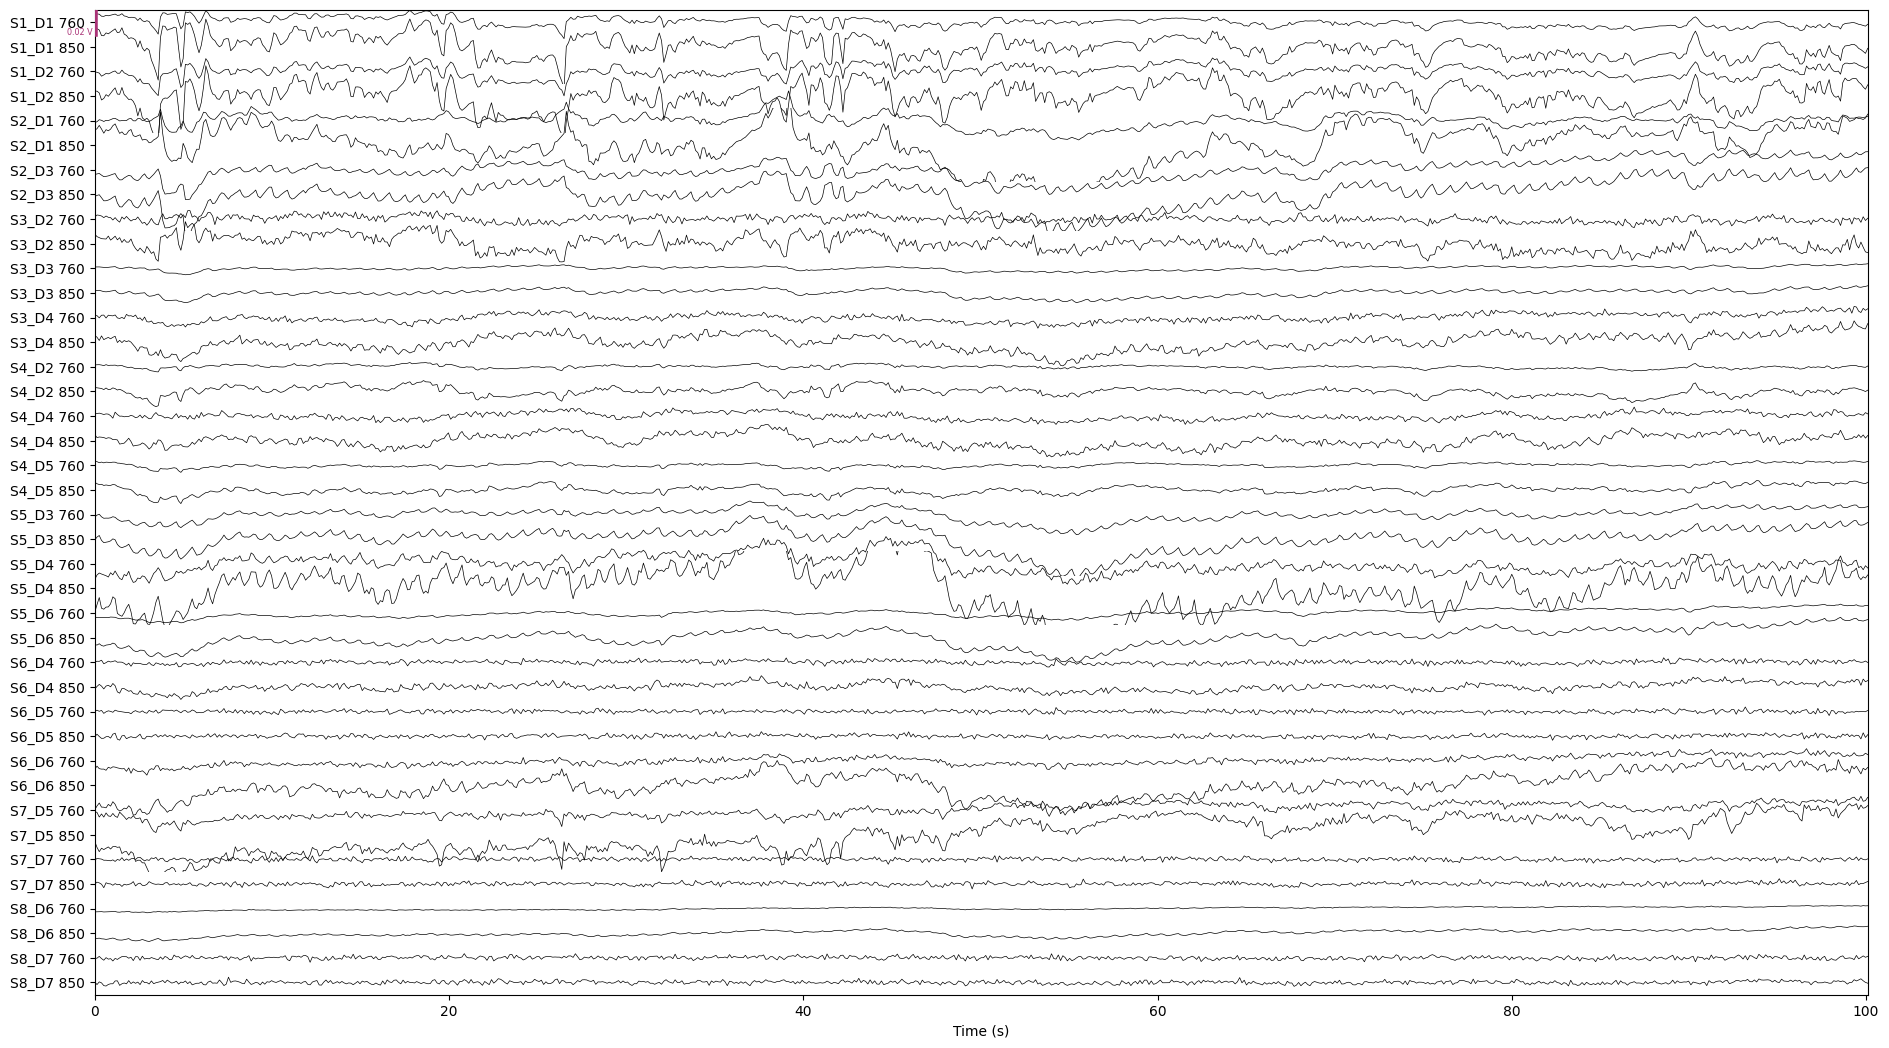

In [6]:
picks = mne.pick_types(raw_parent.info, meg=False, fnirs=True)
dists = mne.preprocessing.nirs.source_detector_distances(raw_parent.info, picks=picks)
raw_parent.pick(picks[dists > 0.01])
raw_parent.plot(n_channels=len(raw_parent.ch_names), duration=100, scalings='auto', show_scrollbars=False)
plt.show()

## Converting from raw intensity to optical density

Reading 0 ... 4885  =      0.000 ...   625.280 secs...


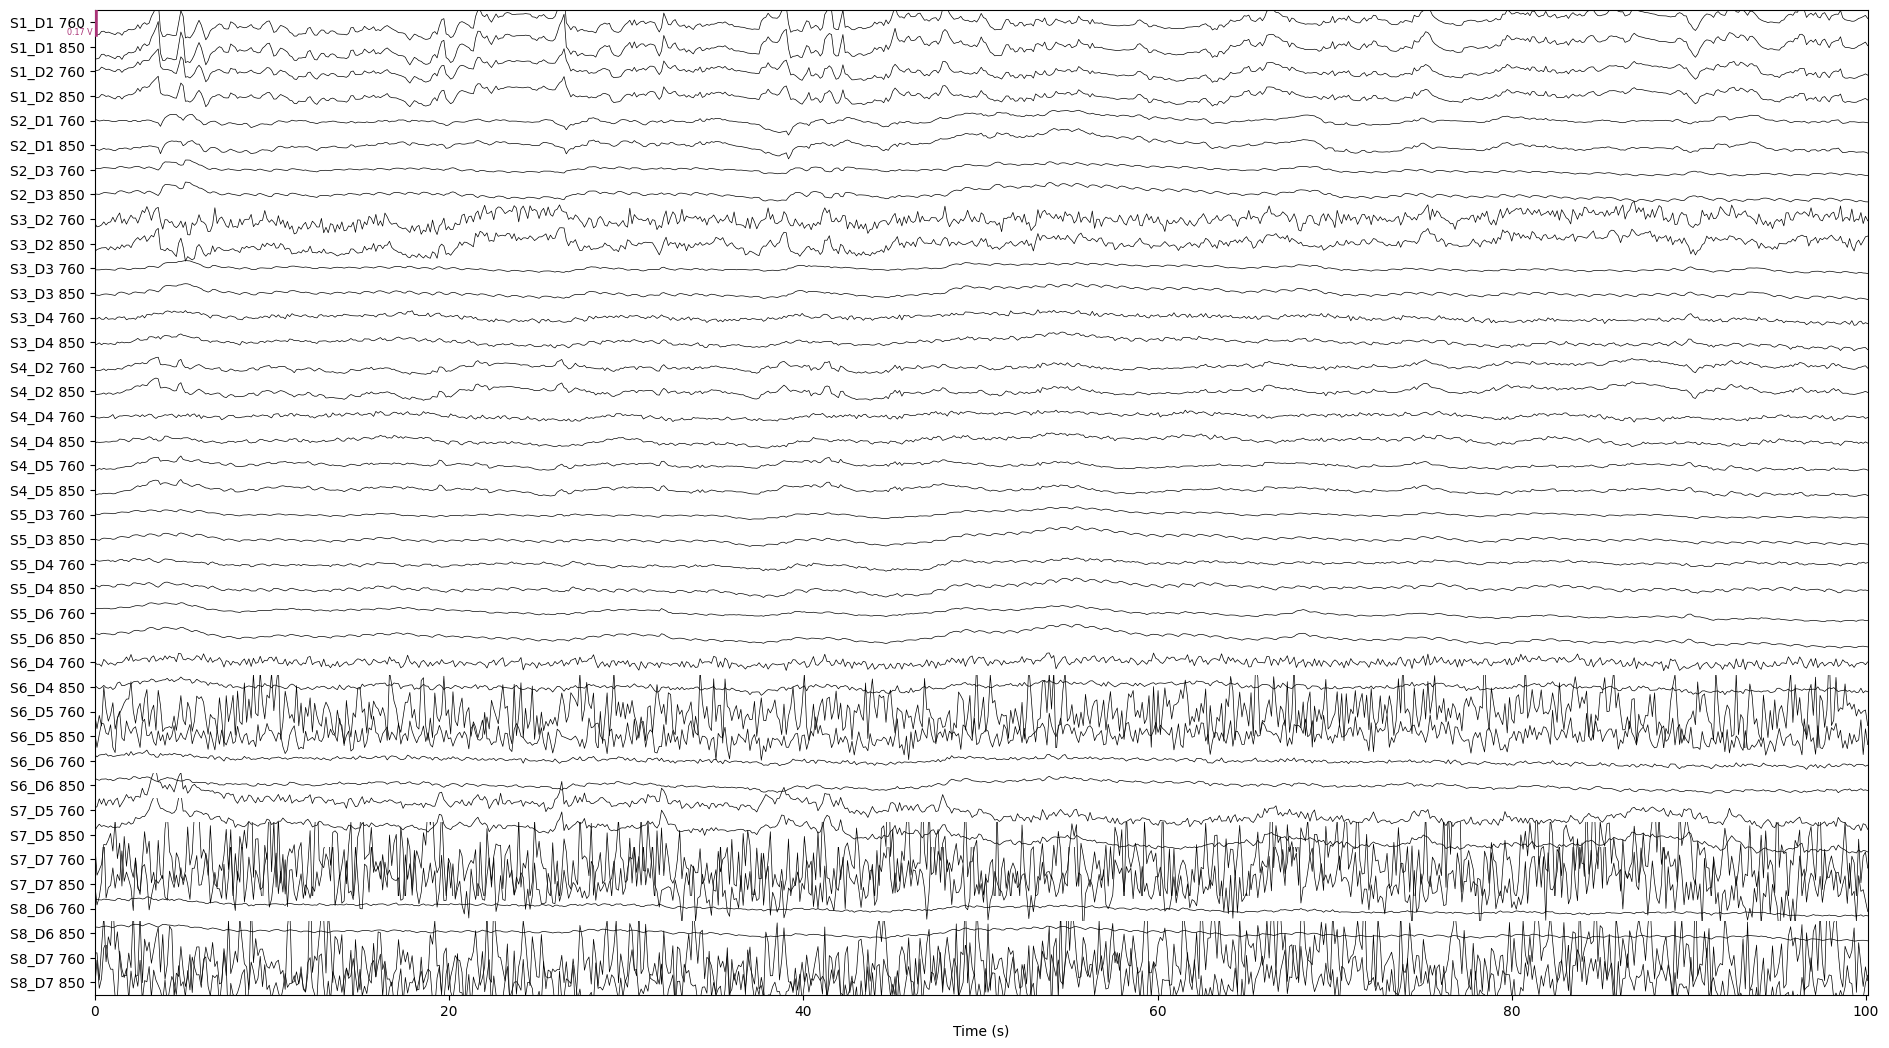

In [7]:
raw_od = mne.preprocessing.nirs.optical_density(raw_parent)
raw_od.plot(n_channels=len(raw_od.ch_names), duration=100, scalings='auto', show_scrollbars=False)
plt.show()


## Quality check

Note: The scalp coupling index (SCI) looks for the presence of a prominent synchronous signal in the frequency range of cardiac signals across both photodetected signals. A common threshold for good quality is keeping channels with SCI > 0.5.


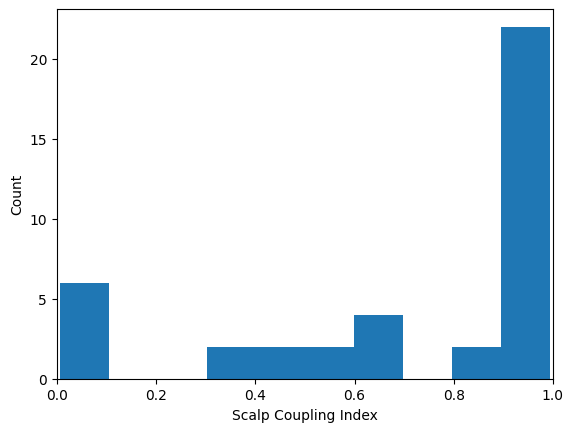

In [8]:
sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
fig, ax = plt.subplots()
ax.hist(sci)
ax.set(xlabel='Scalp Coupling Index', ylabel='Count', xlim=[0, 1])
plt.show()

raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < 0.1))
picks = mne.pick_types(raw_od.info, meg=False, fnirs=True, exclude='bads')
raw_od_clean = raw_od.copy().pick(picks)

## Converting from optical density to haemoglobin

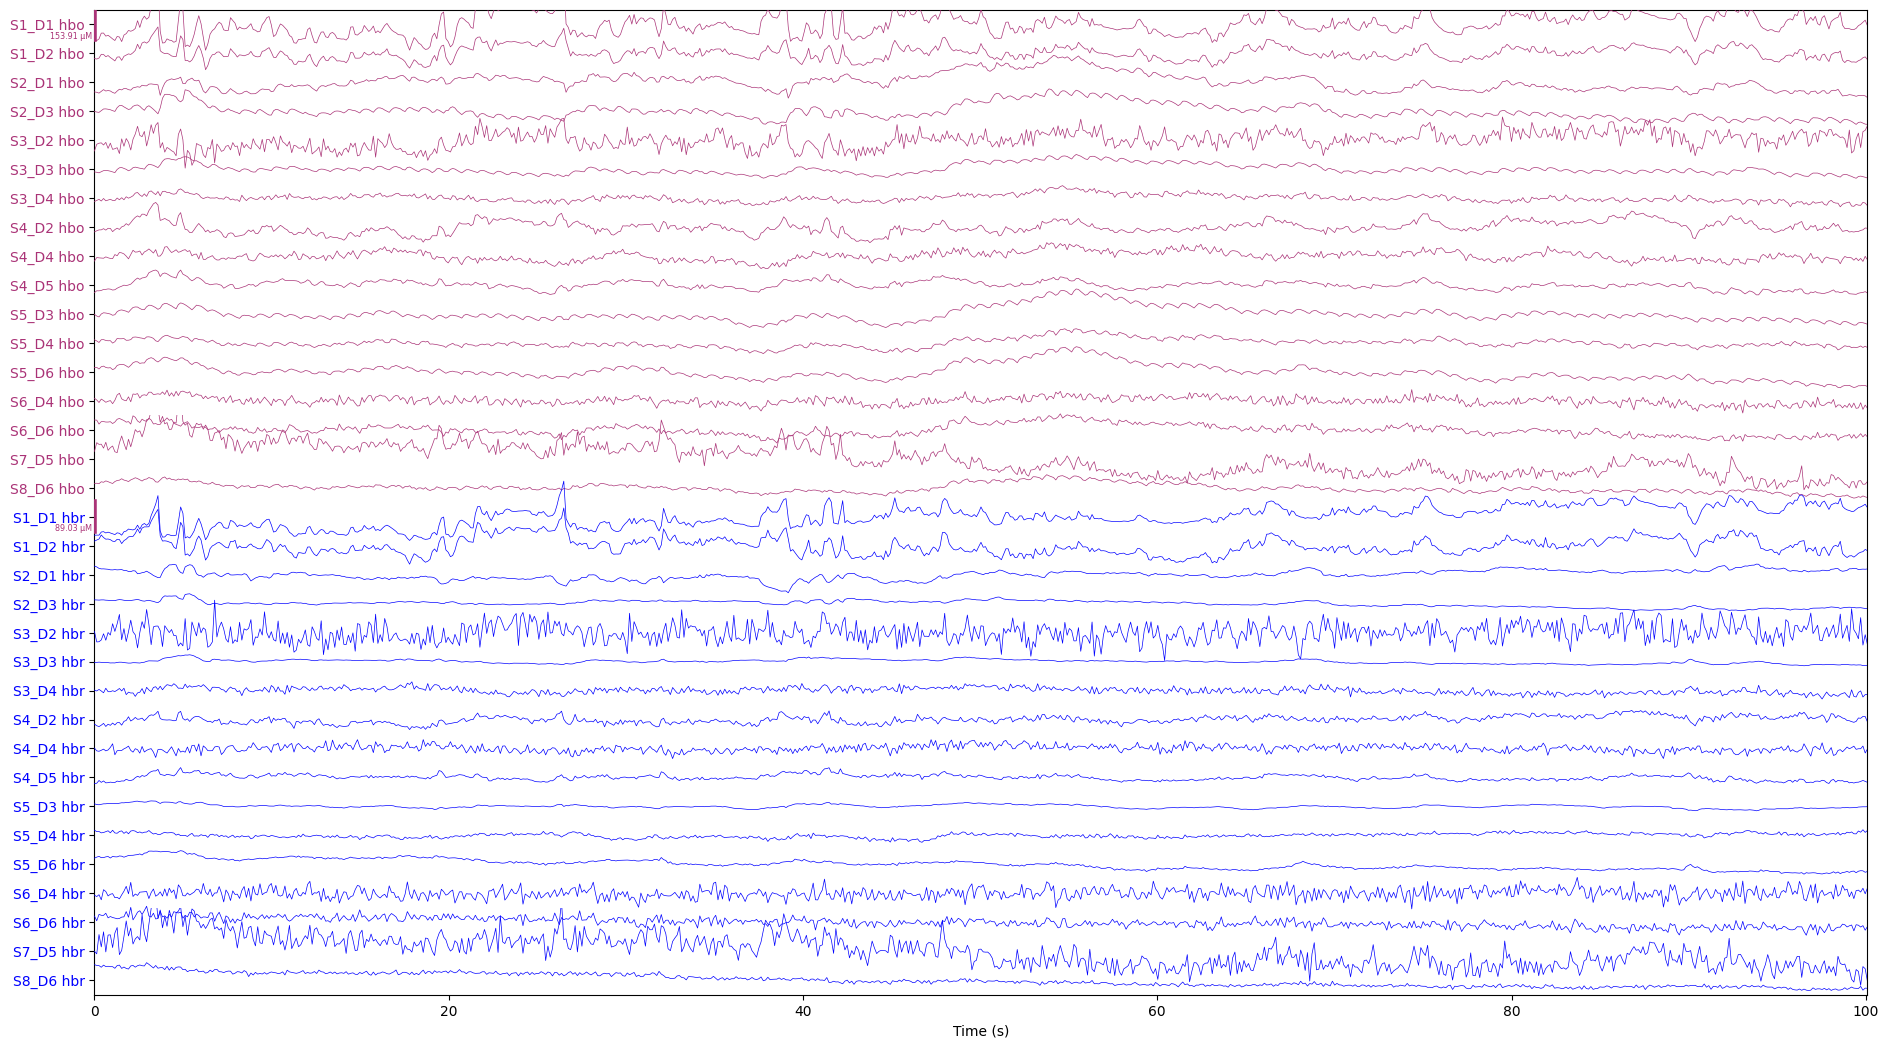

In [9]:
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od_clean, ppf=0.1)
raw_haemo.plot(n_channels=len(raw_haemo.ch_names), duration=100, scalings='auto', show_scrollbars=False, theme="light")
plt.show()

## Removing heart rate from signal

Effective window size : 262.144 (s)
Plotting power spectral density (dB=True).


/tmp/ipykernel_5032/334762882.py:1: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig = raw_haemo.compute_psd().plot()


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1291 samples (165.248 s)

Effective window size : 262.144 (s)
Plotting power spectral density (dB=True).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/tmp/ipykernel_5032/334762882.py:5: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  fig = raw_haemo_parent.compute_psd().plot()


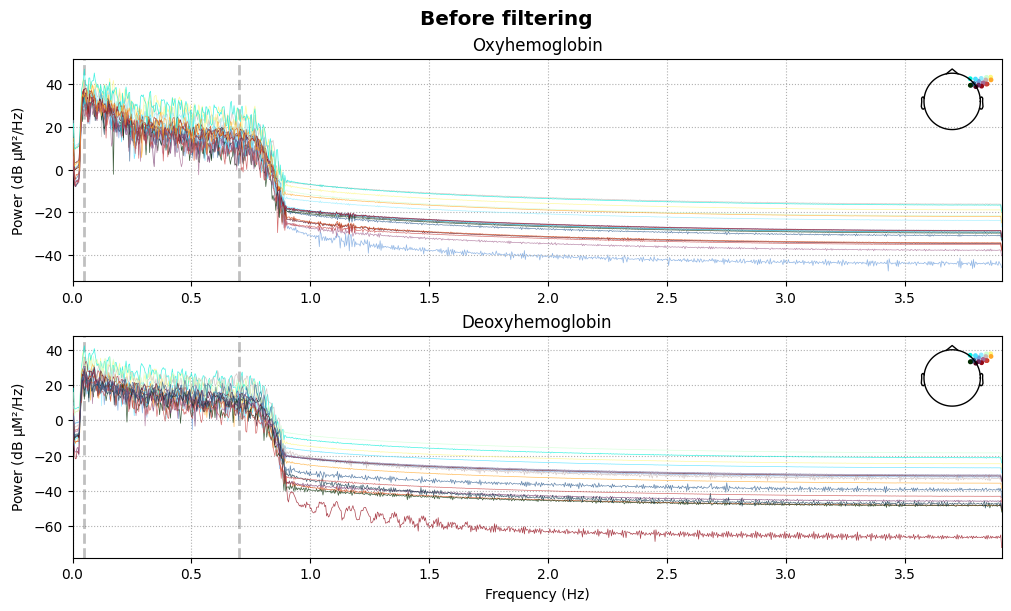

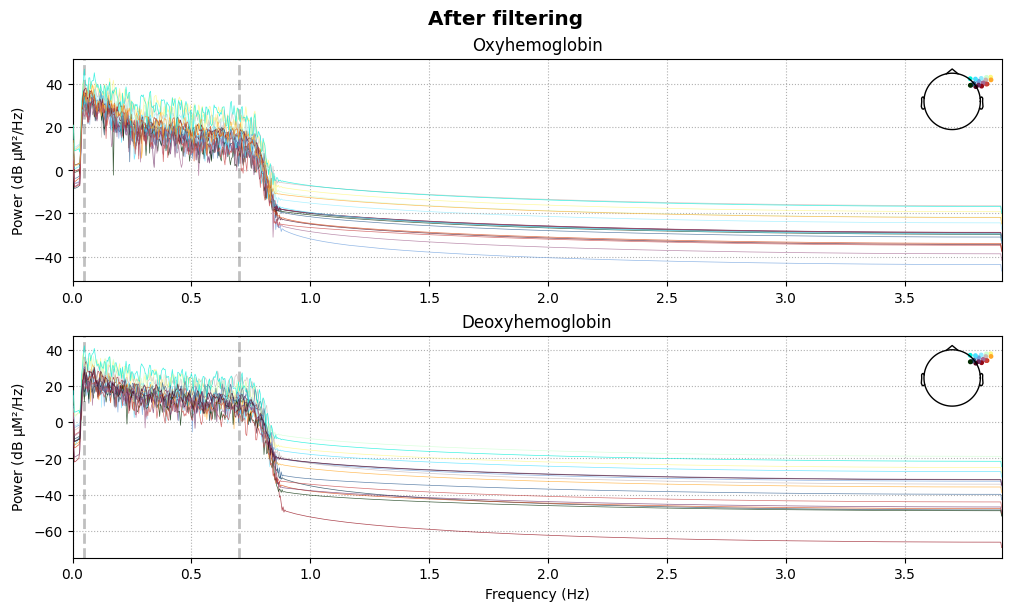

In [11]:
fig = raw_haemo.compute_psd().plot()
fig.suptitle('Before filtering', weight='bold', size='x-large')
fig.subplots_adjust(top=0.88)
raw_haemo_parent = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2, l_trans_bandwidth=0.02)
fig = raw_haemo_parent.compute_psd().plot()
fig.suptitle('After filtering', weight='bold', size='x-large')
fig.subplots_adjust(top=0.88)
plt.show()

## Do the same for the other participant

In [12]:
picks = mne.pick_types(raw_child.info, meg=False, fnirs=True)
dists = mne.preprocessing.nirs.source_detector_distances(raw_child.info, picks=picks)
raw_child.pick(picks[dists > 0.01])
raw_od = mne.preprocessing.nirs.optical_density(raw_child)
sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < 0.1))
picks = mne.pick_types(raw_od.info, meg=False, fnirs=True, exclude='bads')
raw_od_clean = raw_od.copy().pick(picks)
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od_clean, ppf=0.1)
raw_haemo_child = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2, l_trans_bandwidth=0.02)

Reading 0 ... 4885  =      0.000 ...   625.280 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1291 samples (165.248 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


## Import into HyPyP

In [13]:
duration = 30
epo_child = mne.make_fixed_length_epochs(raw_haemo_child, duration=duration, preload=True)
epo_parent = mne.make_fixed_length_epochs(raw_haemo_parent, duration=duration, preload=True)

Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 234 original time points ...
0 bad epochs dropped
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 234 original time points ...
0 bad epochs dropped


## Compute and Visualize Cross-Wavelet Coherence

In [ ]:
freq_bins = 10
freqs = np.linspace(0.05, 1.0, freq_bins)
sfreq = epo_parent.info['sfreq']

data = hypyp.analyses.xwt(epo_child,
           epo_parent,
           freqs=freqs,
           mode='wtc')

In [20]:
np.abs(data).mean(0).mean(0).shape

(20, 10, 234)

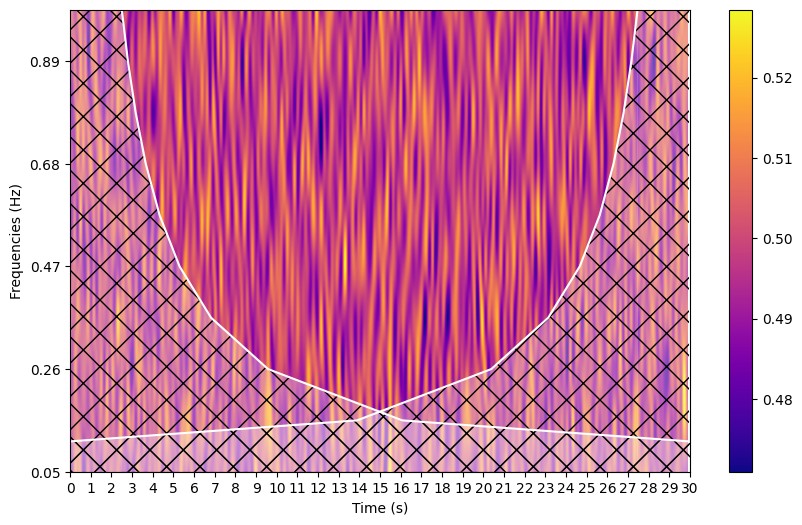

In [22]:
plt.figure(figsize=(10,6))

plt.imshow(np.abs(data).mean(0).mean(0)[1],
           aspect='auto',
           cmap='plasma',
           interpolation='lanczos')

plt.gca().invert_yaxis()
plt.ylabel('Frequencies (Hz)')
plt.xlabel('Time (s)')
plt.yticks(range(0, freq_bins, 2), 
           np.round(100*freqs[range(0, freq_bins, 2)])/100)
plt.ylim([0, freq_bins-1])

smax = data.shape[-1]
plt.xlim([0, smax])
plt.xticks(np.arange(0, smax+sfreq, sfreq), range(duration+1))

coi = 2.5*sfreq/freqs
rev_coi = data.shape[-1]-coi
idx = np.arange(len(freqs))
plt.plot(coi, idx, 'w')
plt.plot(data.shape[-1]-coi, idx, 'w')
plt.fill_between(coi, idx, hatch='X', fc='w', alpha=0.3)
plt.fill_between(rev_coi, idx, hatch='X', fc='w', alpha=0.3)

plt.axvspan(0, min(coi), hatch='X', fc='w', alpha=0.3)
plt.axvspan(smax, max(rev_coi), hatch='X', fc='w', alpha=0.3)

plt.colorbar()

## Now, let's process all the dataset

In [182]:
for dyad in os.listdir(data_path):

    # Load the NIRx data for children and their fathers
    # https://mne.tools/stable/auto_tutorials/io/30_reading_fnirs_data.html

    child_path = os.path.join(data_path, dyad, 'child')
    hdr_child = [f for f in os.listdir(child_path) if f[-3:] == 'hdr'][0]
    raw_child = mne.io.read_raw_nirx(fname=os.path.join(child_path, hdr_child))

    parent_path = os.path.join(data_path, dyad, 'parent')
    hdr_parent = [f for f in os.listdir(parent_path) if f[-3:] == 'hdr'][0]
    raw_parent = mne.io.read_raw_nirx(
        fname=os.path.join(parent_path, hdr_parent))

    # Preprocessing

    # Processing
    # Storing in Pandas dataframe the connectivity

## Statistical Analysis and Visualization

> To be continued...